# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [1]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [2]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [167]:
X["Facility Type"].value_counts()

Restaurant                                         34264
Grocery Store                                       6904
School                                              3876
Bakery                                               846
Daycare (2 - 6 Years)                                830
Children's Services Facility                         802
Daycare Above and Under 2 Years                      656
Long Term Care                                       394
Catering                                             304
Mobile Food Dispenser                                280
Liquor                                               261
Daycare Combo 1586                                   227
Wholesale                                            203
Golden Diner                                         162
Mobile Food Preparer                                 159
Hospital                                             141
TAVERN                                                88
Shared Kitchen User (Long Term)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

In [200]:
X= train.drop(["Fail"],axis=1)
y= train["Fail"]

In [ ]:
["gas station","day care","grocery","catering","bars","banquet","wrigley","rooftop","school","kiosk","care facilities","food truck"]

In [275]:
def mr_clean(X):
    
    X["num_violations"] = X["Violations"].apply(lambda x : str(x).count("|"))
    X["Risk"] = X["Risk"].replace("Risk 1 (High)", 1)
    X["Risk"] = X["Risk"].replace("Risk 2 (Medium)", 2)
    X["Risk"] = X["Risk"].replace("Risk 3 (Low)", 3)
    X["Facility Type"] = X["Facility Type"].str.lower()
    X["gas station"] = X['Facility Type'].str.contains('gas station|convenience', na=False,regex=True)
    X["day care"] = X['Facility Type'].str.contains('daycare', na=False)
    X["grocery"] = X['Facility Type'].str.contains('grocery', na=False)
    X["catering"] = X['Facility Type'].str.contains('catering', na=False)
    X["bars"] = X['Facility Type'].str.contains('tavern|liqour|night club|', na=False,regex=True)
    X["banquet"] = X['Facility Type'].str.contains('banquet|special event|catering|hotel', na=False,regex=True)
    X["wrigley"] = X['Facility Type'].str.contains('wrigley', na=False)
    X["rooftop"] = X['Facility Type'].str.contains('rooftop|roof top', na=False,regex=True)
    X["school"] = X['Facility Type'].str.contains('daycare|private school|charter school|children',na=False,regex=True)
    X["kiosk"] = X['Facility Type'].str.contains('kiosk', na=False)
    X["slaughter"] = X['Facility Type'].str.contains('slaughter|live poutlry', na=False)
    X["has_violations"] = X['Violations'].isnull()
    X["care facilities"] = X['Facility Type'].str.contains('hospital|rehab|assisted living| care',na=False,regex=True)
    X["food truck"] = X['Facility Type'].str.contains('truck|mobile',na=False,regex=True)
    License_Amt = X["License #"].value_counts()
    X["Inspection Type"]
    X = X.join(License_Amt, how='outer',on="License #",lsuffix="_")
    X["Inspection Type"] = X["Inspection Type"].str.lower()
    return X
X = mr_clean(X)

In [205]:
pd.options.display.max_rows = 1000
X["Facility Type"].value_counts()

restaurant                                         34264
grocery store                                       6904
school                                              3880
bakery                                               846
daycare (2 - 6 years)                                830
children's services facility                         802
daycare above and under 2 years                      656
long term care                                       394
catering                                             304
mobile food dispenser                                280
liquor                                               261
daycare combo 1586                                   227
wholesale                                            203
golden diner                                         162
mobile food preparer                                 159
hospital                                             141
tavern                                               103
shared kitchen user (long term)

In [302]:
t = X["Violations"][0].split("|")
t

['3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATURE REQUIREMENT DURING STORAGE, PREPARATION DISPLAY AND SERVICE - Comments: NOTED INTERNAL TEMPERATURES OF THE FOLLOWING HAZARDOUS FOOD ITEMS ON THE PREP TABLE TO BE IMPROPER:-CHICKEN 58.3F, NOODLES 61.7F/55.4F, EGGS 69.8F. MANAGER IMMEDIATELY AND VOLUNTARILY DISPOSED OF 8 LBS OF PRODUCTS WORTH $40.00  THROUGH DENATURING PROCESS. CRITICAL VIOLATION #7-38-005(A) ',
 ' 6. HANDS WASHED AND CLEANED, GOOD HYGIENIC PRACTICES; NO BARE HAND CONTACT WITH READY-TO-EAT FOODS. - Comments: NOTED EMPLOYEE WHILE WEARING GLOVES PERFORMED THE FOLLOWING TASKS:- WASHED DISHES AT THE 3 COMPARTMENT SINK AND DID NOT CHANGES THEIR GLOVES, THEN CONTINUED PREPPING AT THE KITCHEN; CLEANED THE MOUTH AND EAR WITH THE SAME GLOVES ON AND CONTINUED AT THE PREP TABLE STILL WITHOUT CHANGING GLOVES OR WASHING HANDS. FINALLY WENT OUTSIDE OF BUILDING AND RETURNED TO THE KITCHEN TO CONTINUE PREPPING STILL WITHOUT CHANGING GLOVES OR WASHING HANDS. CRITICAL VIOLATION #7-38-010(A

In [319]:
import re
def get_violations(t):
    violations = []
    for i in t:
        i_violations = re.findall('\d+', i[:5])
        violations.append(i_violations)
    violations = [item for sublist in violations for item in sublist]
    return violations


In [320]:
violations = get_violations(t)

In [321]:
violations

['3', '6', '18', '29', '33']

In [314]:
violations = [item for sublist in violations for item in sublist]

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._

In [188]:
import numpy as np
import xgboost as xgb
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score


In [228]:
X["Violations"]

(51916,)

In [231]:
features = ["Facility Type", "Risk","Zip", "Inspection Type", "num_violations", "License #",
           "gas station","day care","grocery","catering","bars","banquet","wrigley","rooftop","school","kiosk",
            "care facilities","food truck","has_violations"]

In [253]:
X[features].head()

,Facility Type,Risk,Zip,Inspection Type,num_violations,License #,gas station,day care,grocery,catering,bars,banquet,wrigley,rooftop,school,kiosk,care facilities,food truck,has_violations
0,restaurant,1.0,60657.0,canvass,4,9240.0,False,False,False,False,True,False,False,False,False,False,False,False,False
15,liquor,3.0,60610.0,license,0,9240.0,False,False,False,False,True,False,False,False,False,False,False,False,True
25,restaurant,1.0,60657.0,license,8,9240.0,False,False,False,False,True,False,False,False,False,False,False,False,False
28,restaurant,1.0,60610.0,license re-inspection,0,9240.0,False,False,False,False,True,False,False,False,False,False,False,False,True
36,restaurant,1.0,60608.0,license re-inspection,0,9240.0,False,False,False,False,True,False,False,False,False,False,False,False,False


# Transformer

In [276]:
features = ["Facility Type", "Risk","Zip", "Inspection Type", "num_violations", "License #",
           "gas station","day care","grocery","catering","bars","banquet","wrigley","rooftop","school","kiosk",
            "care facilities","food truck","has_violations"]
X= train.drop(["Fail"],axis=1)
y= train["Fail"]
X = mr_clean(X)
features = features
X_train, X_test, y_train, y_test = train_test_split(
    X[features], y, test_size=0.2, random_state=42, stratify=y)

,Facility Type,Risk,Zip,Inspection Type,num_violations,License #,gas station,day care,grocery,catering,bars,banquet,wrigley,rooftop,school,kiosk,care facilities,food truck,has_violations
32934,restaurant,2.0,60612.0,complaint re-inspection,0,4.0,False,False,False,False,True,False,False,False,False,False,False,False,True
25153,restaurant,1.0,60608.0,canvass,1,1.0,False,False,False,False,True,False,False,False,False,False,False,False,False
6481,restaurant,3.0,60639.0,complaint re-inspection,3,143.0,False,False,False,False,True,False,False,False,False,False,False,False,False
47541,bakery,2.0,60661.0,canvass re-inspection,7,4.0,False,False,False,False,True,False,False,False,False,False,False,False,False
18671,restaurant,1.0,60605.0,canvass,2,1.0,False,False,False,False,True,False,False,False,False,False,False,False,False
22738,restaurant,1.0,60614.0,license,6,2.0,False,False,False,False,True,False,False,False,False,False,False,False,False
49486,restaurant,1.0,60611.0,canvass re-inspection,8,1.0,False,False,False,False,True,False,False,False,False,False,False,False,False
24254,daycare (2 - 6 years),1.0,60628.0,canvass,3,1.0,False,True,False,False,True,False,False,False,True,False,False,False,False
50643,grocery store,3.0,60634.0,license,0,1.0,False,False,True,False,True,False,False,False,False,False,False,False,True
22853,restaurant,1.0,60659.0,complaint re-inspection,15,5.0,False,False,False,False,True,False,False,False,False,False,False,False,False


In [328]:
def transformer_OH():
    features = ["License #_","Facility Type", "Risk","Zip", "Inspection Type", "num_violations", "License #",
           "gas station","day care","grocery","catering","bars","banquet","wrigley","rooftop","school","kiosk",
            "care facilities","food truck","has_violations"]
    X= train.drop(["Fail"],axis=1)
    y= train["Fail"]
    X = mr_clean(X)
    features = features
    X_train, X_test, y_train, y_test = train_test_split(
        X[features], y, test_size=0.2, random_state=42, stratify=y)
    
    xgb_pipe = make_pipeline(

        ce.OrdinalEncoder(handle_unknown='ignore', cols=['Risk']), 
        ce.OneHotEncoder(handle_unknown='ignore',cols=['Facility Type','Zip','Inspection Type'],use_cat_names=True),

    )
    X_train = xgb_pipe.fit_transform(X_train[features])
    X_test= xgb_pipe.transform(X_test[features])
    return X_train, y_train ,X_test, y_test


In [329]:
 X_train, y_train ,X_test, y_test = transformer_OH()

In [191]:
y_train.value_counts()/len(y_train)

0    0.74138
1    0.25862
Name: Fail, dtype: float64

In [152]:
pd.options.display.max_columns = None

In [262]:
X_train.head()

,Facility Type_1,Facility Type_2,Facility Type_3,Facility Type_4,Facility Type_5,Facility Type_6,Facility Type_7,Facility Type_8,Facility Type_9,Facility Type_10,Facility Type_11,Facility Type_12,Facility Type_13,Facility Type_14,Facility Type_15,Facility Type_16,Facility Type_17,Facility Type_18,Facility Type_19,Facility Type_20,Facility Type_21,Facility Type_22,Facility Type_23,Facility Type_24,Facility Type_25,Facility Type_26,Facility Type_27,Facility Type_28,Facility Type_29,Facility Type_30,Facility Type_31,Facility Type_32,Facility Type_33,Facility Type_34,Facility Type_35,Facility Type_36,Facility Type_37,Facility Type_38,Facility Type_39,Facility Type_40,Facility Type_41,Facility Type_42,Facility Type_43,Facility Type_44,Facility Type_45,Facility Type_46,Facility Type_47,Facility Type_48,Facility Type_49,Facility Type_50,Facility Type_51,Facility Type_52,Facility Type_53,Facility Type_54,Facility Type_55,Facility Type_56,Facility Type_57,Facility Type_58,Facility Type_59,Facility Type_60,Facility Type_61,Facility Type_62,Facility Type_63,Facility Type_64,Facility Type_65,Facility Type_66,Facility Type_67,Facility Type_68,Facility Type_69,Facility Type_70,Facility Type_71,Facility Type_72,Facility Type_73,Facility Type_74,Facility Type_75,Facility Type_76,Facility Type_77,Facility Type_78,Facility Type_79,Facility Type_80,Facility Type_81,Facility Type_82,Facility Type_83,Facility Type_84,Facility Type_85,Facility Type_86,Facility Type_87,Facility Type_88,Facility Type_89,Facility Type_90,Facility Type_91,Facility Type_92,Facility Type_93,Facility Type_94,Facility Type_95,Facility Type_96,Facility Type_97,Facility Type_98,Facility Type_99,Facility Type_100,Facility Type_101,Facility Type_102,Facility Type_103,Facility Type_104,Facility Type_105,Facility Type_106,Facility Type_107,Facility Type_108,Facility Type_109,Facility Type_110,Facility Type_111,Facility Type_112,Facility Type_113,Facility Type_114,Facility Type_115,Facility Type_116,Facility Type_117,Facility Type_118,Facility Type_119,Facility Type_120,Facility Type_121,Facility Type_122,Facility Type_123,Facility Type_124,Facility Type_125,Facility Type_126,Facility Type_127,Facility Type_128,Facility Type_129,Facility Type_130,Facility Type_131,Facility Type_132,Facility Type_133,Facility Type_134,Facility Type_135,Facility Type_136,Facility Type_137,Facility Type_138,Facility Type_139,Facility Type_140,Facility Type_141,Facility Type_142,Facility Type_143,Facility Type_144,Facility Type_145,Facility Type_146,Facility Type_147,Facility Type_148,Facility Type_149,Facility Type_150,Facility Type_151,Facility Type_152,Facility Type_153,Facility Type_154,Facility Type_155,Facility Type_156,Facility Type_157,Facility Type_158,Facility Type_159,Facility Type_160,Facility Type_161,Facility Type_162,Facility Type_163,Facility Type_164,Facility Type_165,Facility Type_166,Facility Type_167,Facility Type_168,Facility Type_169,Facility Type_170,Facility Type_171,Facility Type_172,Facility Type_173,Facility Type_174,Facility Type_175,Facility Type_176,Facility Type_177,Facility Type_178,Facility Type_179,Facility Type_180,Facility Type_181,Facility Type_182,Facility Type_183,Facility Type_184,Facility Type_185,Facility Type_186,Facility Type_187,Facility Type_188,Facility Type_189,Facility Type_190,Facility Type_191,Facility Type_192,Facility Type_193,Facility Type_194,Facility Type_195,Facility Type_196,Facility Type_197,Facility Type_198,Facility Type_199,Facility Type_200,Facility Type_201,Facility Type_202,Facility Type_203,Facility Type_204,Facility Type_205,Facility Type_206,Facility Type_207,Facility Type_208,Facility Type_209,Facility Type_210,Facility Type_211,Facility Type_212,Facility Type_213,Facility Type_214,Facility Type_215,Facility Type_216,Facility Type_217,Facility Type_218,Facility Type_219,Facility Type_220,Facility Type_221,Facility Type_222,Facility Type_223,Facility Type_224,Facility Type_225,Facility Type_226,Facility Type_227,Facility Type_228,Fac

In [330]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {'max_depth': 5,
          'eta': 0.1,
          'silent': 1, 
          'n_jobs': -1,
          'seed': 0,
          'eval_metric': 'auc',
         'tree_method':'gpu_hist'}


xg_bst_cv = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5, early_stopping_rounds=10, as_pandas=True)
xg_bst_cv.head()

C:\Users\cwcol\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.513495,0.004564,0.500390,0.003098
1,0.516751,0.004142,0.501961,0.004366


In [331]:
xgb_boost = xgb.train(params, dtrain, num_boost_round=10)
xgb_boost_predict = xgb_boost.predict(dtest)

In [332]:
xgb_boost_predict = xgb_boost.predict(dtest)
y_true = y_test
y_predict = xgb_boost_predict
roc_auc_score(y_true, y_predict)

0.4920950821202686

### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

### Observations 
* adding more facility gave better numbers for feature importance, but no improvement for ROCAUC

In [333]:
xgb_boost = xgb.train(params, dtrain, num_boost_round=10)

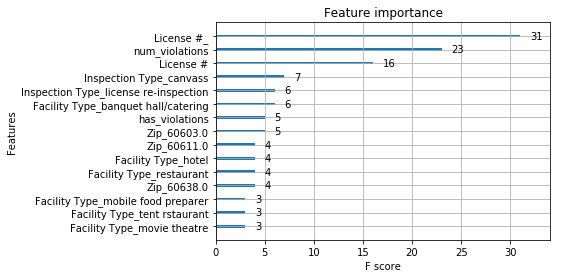

In [334]:
xgb.plot_importance(xgb_boost, max_num_features=15 )